In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.feature_selection import chi2, SelectKBest

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

In [2]:
df= pd.read_csv('heart.csv')

In [3]:

# Separate the minority and majority classes
minority_class = df[df['target'] == 0]
majority_class = df[df['target'] == 1]

# Number of instances in each class
n_minority = len(minority_class)
n_majority = len(majority_class)

# Determine the required number of samples
#n_required = max(n_minority, n_majority)
n_required= 3000

# Oversample the minority class if needed
if n_minority < n_required:
    minority_class_oversampled = resample(minority_class,
                                          replace=True,    # Sample with replacement
                                          n_samples=n_required, # Number of samples to match the majority class
                                          random_state=42)  # Seed for reproducibility
else:
    minority_class_oversampled = minority_class.sample(n=n_required, random_state=42)

# Sample the majority class with replacement if needed
if n_majority < n_required:
    majority_class_sampled = resample(majority_class,
                                      replace=True,    # Sample with replacement
                                      n_samples=n_required, # Number of samples to match the minority class
                                      random_state=42)  # Seed for reproducibility
else:
    majority_class_sampled = majority_class.sample(n=n_required, random_state=42)

# Combine the oversampled minority class with the sampled majority class
balanced_train_data_pca = pd.concat([minority_class_oversampled, majority_class_sampled])

# Shuffle the resulting dataset
balanced_train_data_pca = balanced_train_data_pca.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target in the balanced PCA-transformed training dataset
x_train_balanced_pca = balanced_train_data_pca.drop('target', axis=1)
y_train_balanced = balanced_train_data_pca['target']


In [4]:
print(balanced_train_data_pca['target'].value_counts())

target
0    3000
1    3000
Name: count, dtype: int64


In [5]:
y= balanced_train_data_pca['target']
x= balanced_train_data_pca.drop('target', axis= 1)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

# Apply chi-test

In [8]:
chi2_selector = SelectKBest(chi2, k='all')  # Set k to the desired number of top features
chi2_selector.fit(x, y)

SelectKBest(k='all', score_func=<function chi2 at 0x0000021E99050CC0>)

In [9]:
chi2_scores = chi2_selector.scores_

In [10]:
# Create a DataFrame to view feature scores and p-values
chi2_df = pd.DataFrame({'Feature': x.columns, 'Chi2 Score': chi2_scores})
print(chi2_df.sort_values(by='Chi2 Score', ascending=False))

     Feature   Chi2 Score
7    thalach  3455.580392
9    oldpeak  1452.050436
2         cp  1254.973750
11        ca  1105.518170
8      exang   746.025641
4       chol   445.502834
0        age   360.202761
3   trestbps   181.627126
10     slope   173.856560
1        sex   158.386299
12      thal   104.441107
6    restecg    68.062150
5        fbs     9.288991


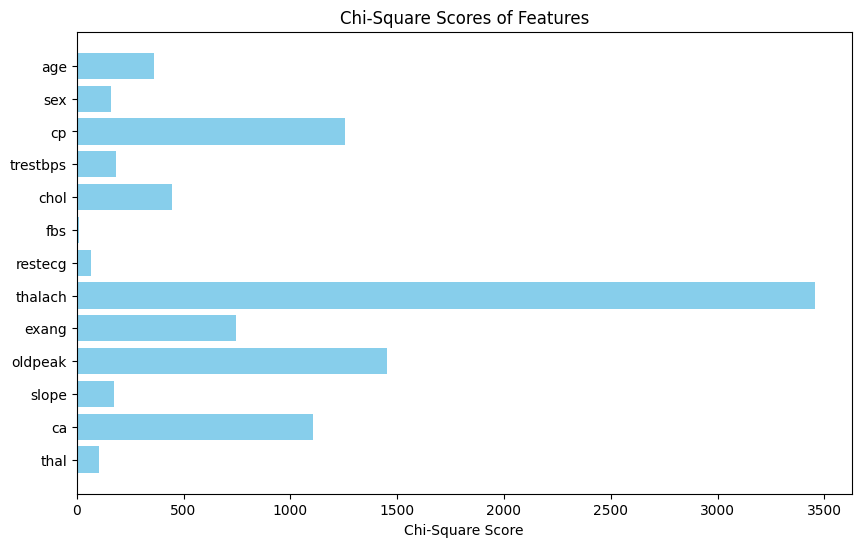

In [11]:
plt.figure(figsize=(10, 6))
plt.barh(chi2_df['Feature'], chi2_df['Chi2 Score'], color='skyblue')
plt.xlabel('Chi-Square Score')
plt.title('Chi-Square Scores of Features')
plt.gca().invert_yaxis()
plt.show()

In [12]:
# Select top features with Chi-Square scores >= 1000
selected_features = chi2_df[chi2_df['Chi2 Score'] >= 200]['Feature']
x_top_features = x[selected_features]

In [13]:
print(selected_features)

0         age
2          cp
4        chol
7     thalach
8       exang
9     oldpeak
11         ca
Name: Feature, dtype: object


In [14]:
x_top_features.shape

(6000, 7)

In [15]:
# Prepare the training and testing data with the selected features
x_train_f = x_train[selected_features]
x_test_f = x_test[selected_features]

# Logistic Regression

In [16]:
model_lr= LogisticRegression(max_iter=1000)
model_lr.fit(x_train_f, y_train)

LogisticRegression(max_iter=1000)

In [17]:
y_train_pred_lr= model_lr.predict(x_train_f)
y_pred_lr= model_lr.predict(x_test_f)

In [18]:
train_accuracy= accuracy_score(y_train, y_train_pred_lr)
train_precision= precision_score(y_train, y_train_pred_lr)
train_recall= recall_score(y_train, y_train_pred_lr)
train_f1= f1_score(y_train, y_train_pred_lr)
accuracy= accuracy_score(y_test, y_pred_lr)
precision= precision_score(y_test, y_pred_lr)
recall= recall_score(y_test, y_pred_lr)
f1= f1_score(y_test, y_pred_lr)

In [19]:
print("Accuracy of train data:", train_accuracy)
print("Precision of train data:", train_precision)
print("Recall of train data:", train_recall)
print("F1-score of train data:", train_f1)

print("\n\nAccuracy of test data:", accuracy)
print("Precision of test data:", precision)
print("Recall of test data:", recall)
print("F1-score of test data:", f1)

Accuracy of train data: 0.8091666666666667
Precision of train data: 0.792578125
Recall of train data: 0.8405136702568351
F1-score of train data: 0.8158423803779654


Accuracy of test data: 0.81
Precision of test data: 0.7868589743589743
Recall of test data: 0.8378839590443686
F1-score of test data: 0.8115702479338843


# naive bayes

In [20]:
nb_model = GaussianNB()
nb_model.fit(x_train_f, y_train)

GaussianNB()

In [21]:
y_train_pred_nb= nb_model.predict(x_train_f)
y_test_pred_nb = nb_model.predict(x_test_f)

In [22]:
train_accuracy_nb = accuracy_score(y_train, y_train_pred_nb)
train_precision_nb = precision_score(y_train, y_train_pred_nb)
train_recall_nb = recall_score(y_train, y_train_pred_nb)
train_f1_nb = f1_score(y_train, y_train_pred_nb)
test_accuracy_nb = accuracy_score(y_test, y_test_pred_nb)
test_precision_nb = precision_score(y_test, y_test_pred_nb)
test_recall_nb = recall_score(y_test, y_test_pred_nb)
test_f1_nb = f1_score(y_test, y_test_pred_nb)

In [23]:
print(f"Training Data Accuracy: {train_accuracy_nb}")
print(f"Training Data Precision: {train_precision_nb}")
print(f"Training Data Recall: {train_recall_nb}")
print(f"Training Data F1 Score: {train_f1_nb}")

print(f"\n\nTest Data Accuracy: {test_accuracy_nb}")
print(f"Test Data Precision: {test_precision_nb}")
print(f"Test Data Recall: {test_recall_nb}")
print(f"Test Data F1 Score: {test_f1_nb}")

Training Data Accuracy: 0.8014583333333334
Training Data Precision: 0.7895362663495838
Training Data Recall: 0.8251864125932062
Training Data F1 Score: 0.8069677942070083


Test Data Accuracy: 0.8158333333333333
Test Data Precision: 0.7938808373590982
Test Data Recall: 0.841296928327645
Test Data F1 Score: 0.8169014084507042


# Neural Network

In [24]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_model.fit(x_train_f, y_train)

MLPClassifier(max_iter=300, random_state=42)

In [25]:
y_train_pred_mlp = mlp_model.predict(x_train_f)
y_test_pred_mlp = mlp_model.predict(x_test_f)

In [26]:
train_accuracy_mlp = accuracy_score(y_train, y_train_pred_mlp)
train_precision_mlp = precision_score(y_train, y_train_pred_mlp)
train_recall_mlp = recall_score(y_train, y_train_pred_mlp)
train_f1_mlp = f1_score(y_train, y_train_pred_mlp)

# Calculate metrics for the test data
test_accuracy_mlp = accuracy_score(y_test, y_test_pred_mlp)
test_precision_mlp = precision_score(y_test, y_test_pred_mlp)
test_recall_mlp = recall_score(y_test, y_test_pred_mlp)
test_f1_mlp = f1_score(y_test, y_test_pred_mlp)

In [27]:
print(f"Training Data Accuracy: {train_accuracy_mlp}")
print(f"Training Data Precision: {train_precision_mlp}")
print(f"Training Data Recall: {train_recall_mlp}")
print(f"Training Data F1 Score: {train_f1_mlp}")

# Print the metrics for the test data
print(f"\n\nTest Data Accuracy: {test_accuracy_mlp}")
print(f"Test Data Precision: {test_precision_mlp}")
print(f"Test Data Recall: {test_recall_mlp}")
print(f"Test Data F1 Score: {test_f1_mlp}")

Training Data Accuracy: 0.8835416666666667
Training Data Precision: 0.8613167121153097
Training Data Recall: 0.915907207953604
Training Data F1 Score: 0.8877735394499097


Test Data Accuracy: 0.8816666666666667
Test Data Precision: 0.8535031847133758
Test Data Recall: 0.9146757679180887
Test Data F1 Score: 0.8830313014827018


# gradient boosting

In [54]:
gb_model = GradientBoostingClassifier()
gb= gb_model.fit(x_train_f, y_train)

In [55]:
print(x_train_f)

      age  cp  chol  thalach  exang  oldpeak  ca
3897   58   1   220      144      0      0.4   4
5628   43   0   177      120      1      2.5   0
1756   55   0   353      132      1      1.2   1
2346   51   2   227      154      1      0.0   1
2996   45   3   264      132      0      1.2   0
...   ...  ..   ...      ...    ...      ...  ..
3772   51   2   222      143      1      1.2   0
5191   44   0   169      144      1      2.8   0
5226   70   0   322      109      0      2.4   3
5390   40   0   223      181      0      0.0   0
860    42   1   295      162      0      0.0   0

[4800 rows x 7 columns]


In [56]:
y_train_pred_gb = gb.predict(x_train_f)
y_test_pred_gb = gb.predict(x_test_f)

In [57]:
train_accuracy_gb = accuracy_score(y_train, y_train_pred_gb)
train_precision_gb = precision_score(y_train, y_train_pred_gb)
train_recall_gb = recall_score(y_train, y_train_pred_gb)
train_f1_gb = f1_score(y_train, y_train_pred_gb)

# Calculate classification metrics for test data (Gradient Boosting)
test_accuracy_gb = accuracy_score(y_test, y_test_pred_gb)
test_precision_gb = precision_score(y_test, y_test_pred_gb)
test_recall_gb = recall_score(y_test, y_test_pred_gb)
test_f1_gb = f1_score(y_test, y_test_pred_gb)

In [58]:
print("Gradient Boosting - Training Data Metrics")
print(f"Accuracy: {train_accuracy_gb}")
print(f"Precision: {train_precision_gb}")
print(f"Recall: {train_recall_gb}")
print(f"F1 Score: {train_f1_gb}")

print("\nGradient Boosting - Test Data Metrics")
print(f"Accuracy: {test_accuracy_gb}")
print(f"Precision: {test_precision_gb}")
print(f"Recall: {test_recall_gb}")
print(f"F1 Score: {test_f1_gb}")


Gradient Boosting - Training Data Metrics
Accuracy: 0.9745833333333334
Precision: 0.9782971619365609
Recall: 0.9710024855012428
F1 Score: 0.9746361746361747

Gradient Boosting - Test Data Metrics
Accuracy: 0.975
Precision: 0.9776632302405498
Recall: 0.9709897610921502
F1 Score: 0.9743150684931506


# Decision tree

In [33]:
dc_model = DecisionTreeClassifier()
dc_model.fit(x_train_f, y_train)

DecisionTreeClassifier()

In [34]:
y_train_pred_dt = dc_model.predict(x_train_f)
y_test_pred_dt = dc_model.predict(x_test_f)

In [35]:
accuracy_train= accuracy_score(y_train, y_train_pred_dt)
precision_train= precision_score(y_train, y_train_pred_dt)
recall_train= recall_score(y_train, y_train_pred_dt)
f1_train= f1_score(y_train, y_train_pred_dt)

accuracy= accuracy_score(y_test, y_test_pred_dt)
precision= precision_score(y_test, y_test_pred_dt)
recall= recall_score(y_test, y_test_pred_dt)
f1= f1_score(y_test, y_test_pred_dt)

In [36]:
print("Accuracy training:", accuracy_train)
print("Precision training:", precision_train)
print("Recall training:", recall_train)
print("F1-score training:", f1_train)
print("\n\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy training: 1.0
Precision training: 1.0
Recall training: 1.0
F1-score training: 1.0


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


# Random forest

In [37]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(x_train_f, y_train)

RandomForestClassifier()

In [38]:
y_train_pred_rf = rf_model.predict(x_train_f)
y_test_pred_rf = rf_model.predict(x_test_f)

In [39]:
rain_accuracy = accuracy_score(y_train, y_train_pred_rf)
train_precision = precision_score(y_train, y_train_pred_rf, average='binary')  
train_recall = recall_score(y_train, y_train_pred_rf, average='binary')        
train_f1 = f1_score(y_train, y_train_pred_rf, average='binary')                

test_accuracy = accuracy_score(y_test, y_test_pred_rf)
test_precision = precision_score(y_test, y_test_pred_rf, average='binary')  
test_recall = recall_score(y_test, y_test_pred_rf, average='binary')         
test_f1 = f1_score(y_test, y_test_pred_rf, average='binary')   

In [40]:
print(f"Training Data Accuracy: {train_accuracy}")
print(f"Training Data Precision: {train_precision}")
print(f"Training Data Recall: {train_recall}")
print(f"Training Data F1 Score: {train_f1}")

print(f"\n\nTest Data Accuracy: {test_accuracy}")
print(f"Test Data Precision: {test_precision}")
print(f"Test Data Recall: {test_recall}")
print(f"Test Data F1 Score: {test_f1}")


Training Data Accuracy: 0.8091666666666667
Training Data Precision: 1.0
Training Data Recall: 1.0
Training Data F1 Score: 1.0


Test Data Accuracy: 1.0
Test Data Precision: 1.0
Test Data Recall: 1.0
Test Data F1 Score: 1.0


# SVM 

In [41]:
from sklearn.svm import SVC
svm_model1= SVC()
svm_model1.fit(x_train_f, y_train)

SVC()

In [42]:
y_train_pred_svc= svm_model1.predict(x_train_f)
y_test_pred_svc = svm_model1.predict(x_test_f)

In [43]:
train_accuracy_svc = accuracy_score(y_train, y_train_pred_svc)
train_precision_svc = precision_score(y_train, y_train_pred_svc)
train_recall_svc = recall_score(y_train, y_train_pred_svc)
train_f1_svc = f1_score(y_train, y_train_pred_svc)

test_accuracy_svc = accuracy_score(y_test, y_test_pred_svc)
test_precision_svc = precision_score(y_test, y_test_pred_svc)
test_recall_svc = recall_score(y_test, y_test_pred_svc)
test_f1_svc = f1_score(y_test, y_test_pred_svc)

In [44]:
print(f"Training Data Accuracy: {train_accuracy_svc}")
print(f"Training Data Precision: {train_precision_svc}")
print(f"Training Data Recall: {train_recall_svc}")
print(f"Training Data F1 Score: {train_f1_svc}")

print(f"Test Data Accuracy: {test_accuracy_svc}")
print(f"Test Data Precision: {test_precision_svc}")
print(f"Test Data Recall: {test_recall_svc}")
print(f"Test Data F1 Score: {test_f1_svc}")

Training Data Accuracy: 0.685625
Training Data Precision: 0.6807830603276068
Training Data Recall: 0.7058823529411765
Training Data F1 Score: 0.6931055521659548
Test Data Accuracy: 0.7191666666666666
Test Data Precision: 0.7011308562197092
Test Data Recall: 0.7406143344709898
Test Data F1 Score: 0.7203319502074689


In [69]:
# input_data= (43,0,341,136,1,3,0)
input_data= (58,0,248,122,0,1,0)
#age, cp, chol, thalach, exang, oldpeak, ca
#changing the input_data to numpy array
input_data_as_numpy_array= np.asarray(input_data)
print(input_data_as_numpy_array)
input_data_reshaped= input_data_as_numpy_array.reshape(1, -1)
print(input_data_reshaped)

prediction = gb_model.predict(input_data_reshaped)
print(prediction)

if(prediction [0] == 0):
    print('the person does not have heart disease')
else: 
    print('the person have heart disease')

[ 58   0 248 122   0   1   0]
[[ 58   0 248 122   0   1   0]]
[1]
the person have heart disease


c:\Users\hp\.conda\envs\sandy\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [59]:
import pickle

In [60]:
fname= '../HeartDiseaseModel/HDModel.sav'

In [61]:
pickle.dump(gb, open(fname, 'wb'))

In [62]:
loaded_model= pickle.load(open(fname, 'rb'))

In [70]:
# input_data= (43,0,341,136,1,3,0)
input_data= (58,0,248,122,0,1,0)
#changing the input_data to numpy array
input_data_as_numpy_array= np.asarray(input_data)
#reshape the array as we are predicting for one instance
input_data_reshaped= input_data_as_numpy_array.reshape(1, -1)

prediction = loaded_model.predict(input_data_reshaped)

if(prediction [0] == 0):
    print('the person does not have heart disease')
else: 
    print('the person have heart disease')

the person have heart disease


c:\Users\hp\.conda\envs\sandy\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [51]:
x.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [52]:
for column in x.columns:
    print(column)

age
sex
cp
trestbps
chol
fbs
restecg
thalach
exang
oldpeak
slope
ca
thal
